# Tugas 1 Convolutional Neural Network Milestone A
- 13520116 Mahesa Lizardy
- 13520146 Bryan Amirul Husna

In [1]:
# preprocess images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
batch_size = 25
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)


def create_data_sparse():
    # data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
    #                               height_shift_range=0.2, zoom_range=0.2)
    data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

    train_images = data_gen.flow_from_directory('Dataset/PandasBears/Train', 
                                                target_size=(img_height, img_width),
                                                class_mode='binary', 
                                                batch_size=500, 
                                                subset='training', 
                                                # color_mode='rgb'
                                                )
    
    
    test_images = data_gen.flow_from_directory('Dataset/PandasBears/Test', 
                                               target_size=(img_height, img_width),
                                               class_mode='binary', 
                                               batch_size=200, 
                                               shuffle=False, 
                                            #    color_mode='rgb'
                                               )

    return train_images, test_images

train_images, test_images = create_data_sparse()

labels = ['bear', 'panda']

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [2]:
print(len(train_images[0][0]))

400


In [3]:
X_train = train_images[0][0]
y_train = train_images[0][1]

X_test = test_images[0][0]
y_test = test_images[0][1]

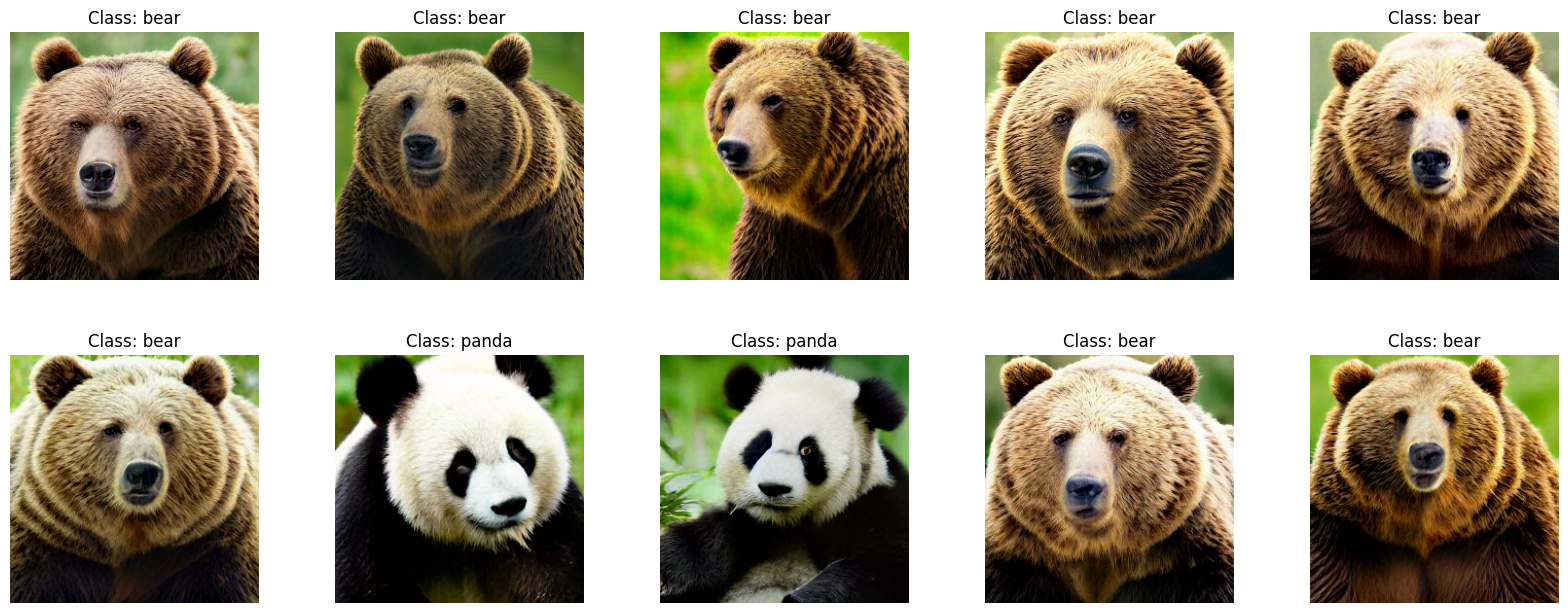

In [4]:
plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(X_train[i])
    plt.title(f"Class: {labels[int(y_train[i])]}")
    plt.axis('off')


In [5]:
# import from src
from src.Model import Model
from src.Convolution import Convolution
from src.Dense import Dense
from src.Pooling import Pooling
from src.Flatten import Flatten

In [6]:
# Buat model, dengan weights bernilai random
samples = next(train_images)
input_shape = samples[0][0].shape

model = Model()
model.add(Convolution(input_size=input_shape, padding_size=1, filter_size=(3, 3), num_filters=2, stride=1, bias=0))
model.add(Pooling(filter_size = (32,32), stride=32, mode='max'))
model.add(Flatten())
model.add(Dense(num_units=7, activation_function="relu"))
model.add(Dense(num_units=1, activation_function="sigmoid"))

In [7]:
# Prediksi
y_p = model.predict(X_test[0:5])
print(y_p)

[[9.89365197e-22]
 [2.47779341e-19]
 [9.92786342e-18]
 [5.11667884e-22]
 [1.73297854e-20]]


In [11]:
# Kesimpulan prediksi
y_predicted = np.array([0. if y < 0.5 else 1. for y in y_p])
print("Actual y:", y_test[:5])
print("Predicted y:", y_predicted)

Actual y: [0. 0. 0. 0. 0.]
Predicted y: [0. 0. 0. 0. 0.]


In [12]:
# Perbandingan dengan Keras
# Bobot model (layer 0 (convolution), 3 (dense), dan 4 (dense))
# Konversi weights filter ke formatnya keras
l0_filters = model.layers[0].filter
f = len(l0_filters)
h = len(l0_filters[0])
w = len(l0_filters[0][0])
d = len(l0_filters[0][0][0])

r = []
for i in range(h):
    r.append([])
    for j in range(w):
        r[i].append([])
        for k in range(d):
            r[i][j].append([])
            for l in range(f):
                r[i][j][k].append(l0_filters[l][i][j][k])
l0_weights = np.array(r)
l0_bias = model.layers[0].bias

# Weights untuk dense sudah compatible dengan formatnya keras
l3_weights = model.layers[3].weights
l3_bias = model.layers[3].bias
l4_weights = model.layers[4].weights
l4_bias = model.layers[4].bias

In [13]:
# Perbandingan dengan Keras
import tensorflow.keras as keras

In [14]:
model_k = keras.models.Sequential()
model_k.add(keras.layers.Conv2D(filters=2, kernel_size=(3, 3), activation="relu", strides=(1,1), padding="same", input_shape=input_shape))
model_k.add(keras.layers.MaxPooling2D(pool_size=(32,32), strides=32))
model_k.add(keras.layers.Flatten())
model_k.add(keras.layers.Dense(units=7, activation="relu"))
model_k.add(keras.layers.Dense(units=1, activation="sigmoid"))
            
model_k.compile()

model_k.layers[0].set_weights([l0_weights, l0_bias])
model_k.layers[3].set_weights([l3_weights, l3_bias])
model_k.layers[4].set_weights([l4_weights, l4_bias])

In [15]:
model_k.predict(X_test[:5])

1/1 [==============================] - 0s 282ms/step


array([[9.8936133e-22],
       [2.4778244e-19],
       [9.9278862e-18],
       [5.1166306e-22],
       [1.7330027e-20]], dtype=float32)